# XOR 
## Example from *Machine Learning with PyTorch and Scikit-Learn* ch. 13

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [3]:
torch.manual_seed(1)
np.random.seed(1)

### Create training and validation data.
1. Generate random pairs in range [-1,1]
2. Assign labels based on the XOR rule below
3. Create even test/validation split

In [4]:
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(200)
y[x[:,0] * x[:, 1] < 0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)

x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

Text(0, 0.5, '$x_2$')

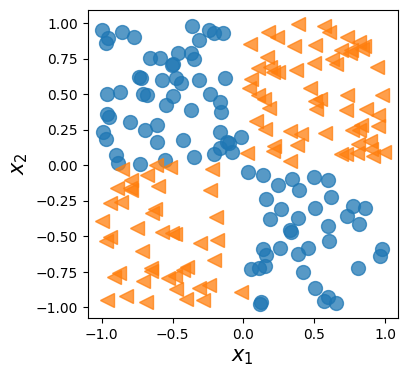

In [6]:
fig = plt.figure(figsize=(4, 4))

plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

In [7]:
import torch.nn as nn

### Create first model iteration using nn.Sequential

In [8]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

In [16]:
# binary cross-entropy loss and stochastic gradient descent
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Create data objects to pass to model trainer

In [12]:
from torch.utils.data import DataLoader, TensorDataset

In [13]:
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

### Define a trainer

In [17]:
torch.manual_seed(1)
num_epochs = 200

def train(model, num_epochs, train_dl, x_valid, y_valid):

    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()
        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size
        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid


In [18]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

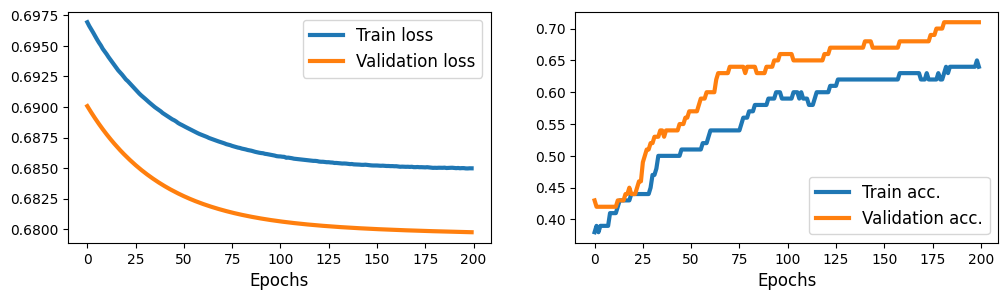

In [21]:
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=3)
plt.plot(history[1], lw=3)
plt.legend(['Train loss', 'Validation loss'], fontsize=12)
ax.set_xlabel('Epochs', size=12)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=3)
plt.plot(history[3], lw=3)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=12)
ax.set_xlabel('Epochs', size=12)

Notice the relatively large error above. 

### Define a new model with a hidden layer

In [22]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

In [23]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

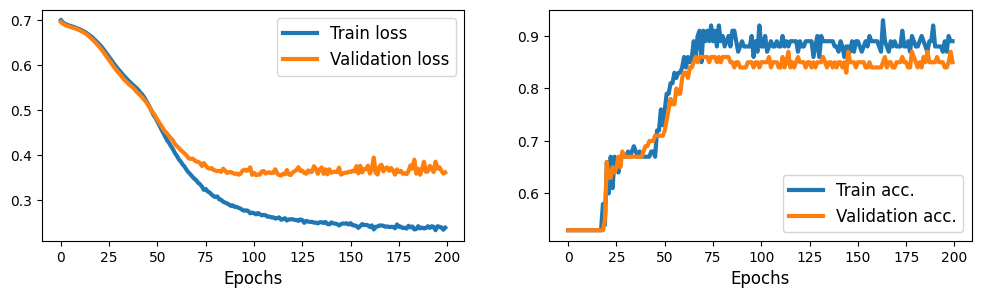

In [24]:
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=3)
plt.plot(history[1], lw=3)
plt.legend(['Train loss', 'Validation loss'], fontsize=12)
ax.set_xlabel('Epochs', size=12)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=3)
plt.plot(history[3], lw=3)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=12)
ax.set_xlabel('Epochs', size=12)

Error is reduced, but there's clearly overfitting.

### Create another model, this time by subclassing nn.Module
This requires defining \_\_init\_\_ and forward methods. I'm not sure why the authors use class attributes to define the layers.

In [35]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable parameters are initialized according to a default scheme.
        # For nn.Linear, that is Uniform(-1/sqrt(in_features), 1/sqrt(in_features))
        # cf. https://pytorch.org/tutorials/prototype/skip_param_init.html
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        # Notice how assignment of x to f(x) composes every submodule in the list sequentially.
        # It's possible to combine in different ways when defining a Module subclass --
        # I believe this is the same as using Sequential.
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

In [40]:
model = MyModule()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

In [41]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [42]:
from mlxtend.plotting import plot_decision_regions

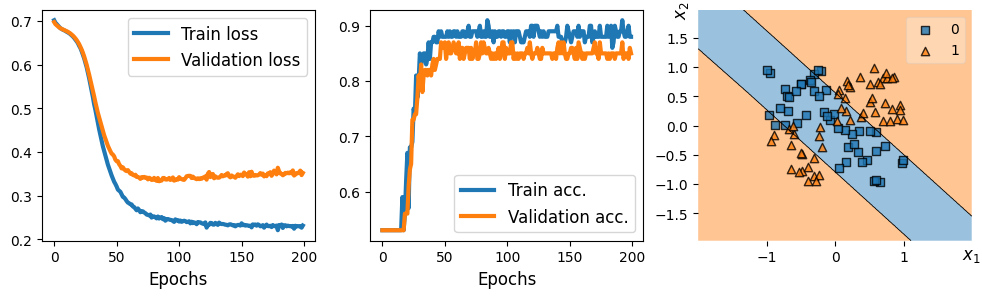

In [43]:
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=3)
plt.plot(history[1], lw=3)
plt.legend(['Train loss', 'Validation loss'], fontsize=12)
ax.set_xlabel('Epochs', size=12)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=3)
plt.plot(history[3], lw=3)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=12)
ax.set_xlabel('Epochs', size=12)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int32),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=12)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=12)
ax.yaxis.set_label_coords(-0.025, 1)

Really interesting set of outcomes from running this a few times. 
1. The decision boundary varies wildly. On the first two runs, it only identified the upper left region as 0. Clearly it came up with a "creative" solution here. 
2. On one run, the error was really stable and high for about half the epochs and then quickly dropped. Sometimes it had pretty wide swings. 

I suspect the main culprit is the learning rate, which is relatively high. That doesn't explain why the Sequential model seems more consistent.

### Create a custom layer that introduces its own noise

In [45]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        # Set up custom parameter as a tensor and then use it as a parameter and define its 
        # initialization scheme.
        w = torch.Tensor(input_size, output_size)
        # So far I know that using the Parameter class inside a Module adds that attribute to the 
        # parameter list, but I haven't been able to figure out how that works and if/when it's unnecessary.
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        # Only add noise to input when training.
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

### Create a model with a noisy layer for the XOR task

In [46]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        # again not clear to me why the authors choose class vs. instance attributes when they do
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
    
    def forward(self, x, training=False):
        # also not clear why we don't create a parameter list and iterate, as we did above
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

In [50]:
torch.manual_seed(1)
model = MyNoisyModule()
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

In [52]:
torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, training=True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = (
            (pred>=0.5).float() == y_batch
        ).float()
        accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

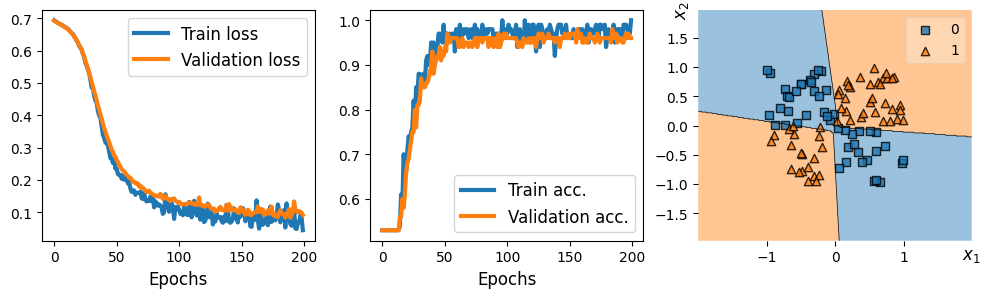

In [54]:
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=3)
plt.plot(loss_hist_valid, lw=3)
plt.legend(['Train loss', 'Validation loss'], fontsize=12)
ax.set_xlabel('Epochs', size=12)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=3)
plt.plot(accuracy_hist_valid, lw=3)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=12)
ax.set_xlabel('Epochs', size=12)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(
    X=x_valid.numpy(),
    y=y_valid.numpy().astype(np.int32),
    clf=model
)
ax.set_xlabel(r'$x_1$', size=12)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=12)
ax.yaxis.set_label_coords(-0.025, 1)

*the power of noise?*

The authors say that there isn't a marked performance improvement, but this version looks better in every respect to the multiple runs with the custom module without noise. If the learning rate isn't to blame, I may have neglected to properly set the random state for consistent performance on those previous runs. This is something I need to understand better. That would explain the inconsistency, but not the consistently poor performance, unless we got bad initializers every time. Note that this noisy version used the Xavier initializer, where the others didn't. 